In [1]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd
from os import listdir
import cv2
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

In [2]:
print(f"The number of image withot mask: {len(os.listdir('dataset/without_mask'))}")
print(f"The number of image wit mask: {len(os.listdir('dataset/with_mask'))}")

The number of image withot mask: 635
The number of image wit mask: 644


In [3]:
def split_data(sourse, train, test, split_size):
    dataset = []
    
    for unitData in os.listdir(sourse):
        data = os.path.join(sourse, unitData)
        if(os.path.getsize(data) > 0):
            dataset.append(unitData)
        else:
            print('Skipped ' + unitData)
            print('Invalid file i.e zero size')
    
    train_set_length = int(len(dataset) * split_size)
    test_set_length = int(len(dataset) - train_set_length)
    shuffled_set = random.sample(dataset, len(dataset))
    train_set = dataset[0:train_set_length]
    test_set = dataset[-test_set_length:]
       
    for unitData in train_set:
        temp_train_set = os.path.join(sourse, unitData)
        final_train_set = os.path.join(train, unitData)
        copyfile(temp_train_set, final_train_set)
    
    for unitData in test_set:
        temp_test_set = os.path.join(sourse, unitData)
        final_test_set = os.path.join(test, unitData)
        copyfile(temp_test_set, final_test_set)

In [4]:
mask_sourse = "dataset/with_mask"
without_mask_sourse = "dataset/without_mask"
train_mask_sourse = "dataset/train/mask"
train_without_mask = "dataset/train/without_mask"
test_mask_sourse = "dataset/test/mask"
test_without_mask = "dataset/test/without_mask"

In [5]:
split_size = 0.8

In [6]:
split_data(mask_sourse, train_mask_sourse, test_mask_sourse, split_size)

In [7]:
split_data(without_mask_sourse, train_without_mask, test_without_mask, split_size)

In [8]:
print(f"The number of train image withot mask: {len(os.listdir('dataset/train/without_mask'))}")
print(f"The number of train image with mask: {len(os.listdir('dataset/train/mask'))}")

The number of train image withot mask: 508
The number of train image with mask: 515


In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(100, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(100, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [10]:
train_path = "dataset/train"
test_path = "dataset/test"

In [11]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

In [12]:
train_generator = train_datagen.flow_from_directory(train_path, 
                                                    batch_size=10, 
                                                    target_size=(150, 150))

Found 1023 images belonging to 2 classes.


In [13]:
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(test_path, 
                                                    batch_size=10, 
                                                    target_size=(150, 150))

Found 256 images belonging to 2 classes.


In [19]:
history = model.fit_generator(train_generator,
                              epochs=30,
                              validation_data=test_generator)

C:\Users\akim5\AppData\Local\Temp\ipykernel_14120\4119398508.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/30
103/103 [==============================] - 35s 339ms/step - loss: 0.2781 - acc: 0.8993 - val_loss: 0.3127 - val_acc: 0.8750
Epoch 2/30
103/103 [==============================] - 35s 340ms/step - loss: 0.2149 - acc: 0.9247 - val_loss: 0.1625 - val_acc: 0.9531
Epoch 3/30
103/103 [==============================] - 35s 340ms/step - loss: 0.2096 - acc: 0.9198 - val_loss: 0.1435 - val_acc: 0.9648
Epoch 4/30
103/103 [==============================] - 35s 342ms/step - loss: 0.1986 - acc: 0.9257 - val_loss: 0.1577 - val_acc: 0.9531
Epoch 5/30
103/103 [==============================] - 36s 345ms/step - loss: 0.2062 - acc: 0.9257 - val_loss: 0.1336 - val_acc: 0.9570
Epoch 6/30
103/103 [==============================] - 35s 341ms/step - loss: 0.1703 - acc: 0.9384 - val_loss: 0.1192 - val_acc: 0.9609
Epoch 7/30
103/103 [==============================] - 35s 341ms/step - loss: 0.1908 - acc: 0.9306 - val_loss: 0.1180 - val_acc: 0.9609
Epoch 8/30
103/103 [==============================] - 3

In [20]:
face_clsfr=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [22]:
labels_dict={0:'without_mask',1:'with_mask'}
color_dict={0:(0,0,255),1:(0,255,0)}

size = 4
webcam = cv2.VideoCapture(1) #Use camera 1

# We load the xml file
classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

while True:
    (rval, im) = webcam.read()
    im=cv2.flip(im,1,1) #Flip to act as a mirror

    # Resize the image to speed up detection
    mini = cv2.resize(im, (im.shape[1] // size, im.shape[0] // size))

    # detect MultiScale / faces 
    faces = classifier.detectMultiScale(mini)

    # Draw rectangles around each face
    for f in faces:
        (x, y, w, h) = [v * size for v in f] #Scale the shapesize backup
        #Save just the rectangle faces in SubRecFaces
        face_img = im[y:y+h, x:x+w]
        resized=cv2.resize(face_img,(150,150))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,150,150,3))
        reshaped = np.vstack([reshaped])
        result=model.predict(reshaped)
        #print(result)
        
        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(im,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(im,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(im, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
    # Show the image
    cv2.imshow('LIVE',   im)
    key = cv2.waitKey(10)
    # if Esc key is press then break out of the loop 
    if key == 'q': #The Esc key
        break
# Stop video
webcam.release()

# Close all started windows
cv2.destroyAllWindows()

1/1 [==============================] - 0s 34ms/step


KeyboardInterrupt: 

In [26]:
mask_image = cv2.imread('mask.jpg')
mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB)
no_mask = cv2.imread('without_mask.jpg')
no_mask = cv2.cvtColor(no_mask, cv2.COLOR_BGR2RGB)

Text(0.5, 1.0, 'class No Mask')

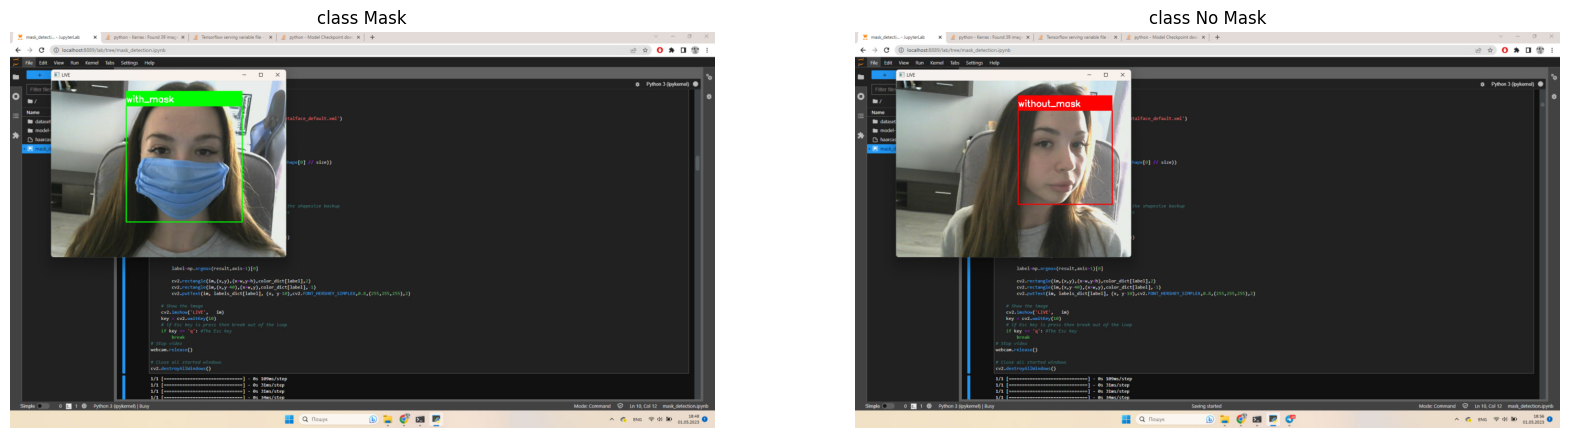

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(20,10))
axs[0].imshow(mask_image)
axs[0].axis('off')
axs[0].set_title('class Mask')
axs[1].imshow(no_mask)
axs[1].axis('off')
axs[1].set_title('class No Mask')